In [3]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
!pwd
%cd /content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)/2016-2019(before covid)

/content
/content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)/2016-2019(before covid)


In [5]:
# sector-> Food & Drug store(2016/01/01~2019/12/31) 
import pandas as pd
df1=pd.read_csv("SVNDY.csv") 
df2=pd.read_csv("WBA.csv")  
df3=pd.read_csv("MTRAF.csv")
df4=pd.read_csv("COOP.csv") 
df5=pd.read_csv("JSAIY.csv")  
df6=pd.read_csv("ADRNY.csv")  
df7=pd.read_csv("TSCDY.csv")  
df8=pd.read_csv("KR.csv")    
df9=pd.read_csv("AGHC.csv")  
df10=pd.read_csv("CRRFY.csv") 
df11=pd.read_csv("WNGRF.csv") 

data=[df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)',
    "Royal Ahold Delhaize(Netherlands)", "Tesco(Britain)", "Kroger(USA)", "AEON(Japan)", "Carrefour(France)", "George Weston(Canada)"]

print(df1.shape, df2.shape, df3.shape, df4.shape, df5.shape, df6.shape, df7.shape, df8.shape, df9.shape, df10.shape, df11.shape)

(1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8)


# Make models

In [6]:
from keras.layers import *
def make_models(c, nl, v, V=False, output_c=['High'], output_i=[2], outputs_company=1, cross_validation=True, train_size=754, time_step=60, epochs=30, units=50): 
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping
  """
  items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}
  v=[1, 2, 3, 4, 6]  
  output_c=['High']
  output_i=[2] 　"""
  
  #1. split train and test data
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  #2. train_data->normalise depending on number of inputs (only the volume is processed separately as the scale is different)
  #3. make X_train, y_train flexibly
  X_train=[]
  y_trains=[]
  
  if len(output_i) != 1:
    print(f"output>=2, inputs={v}, outputs={output_c}")
    training_set_others=np.hstack((data[:,:-1] for data in train_data))
    training_set_volume=np.hstack((data[:,-1:].reshape(-1, 1) for data in train_data))

    ss_others=[]
    for i in range(training_set_others.shape[1]):
      ss1=StandardScaler()
      ss_others.append(ss1.fit_transform(training_set_others[:,i].reshape(-1, 1)))
    ss_others=np.hstack(ss_others)

    ss2=StandardScaler()
    ss_v=ss2.fit_transform(training_set_volume)
    concat=np.hstack((ss_others, ss_v))
    print(f"concat={concat.shape}")

    #ind=output用のvariablesのindexを抜き取る=>個別に学習モデルを作成するため
    if 6 in output_i: 
      print("Volume含む")
      ind = []
      for i in range(len(output_i)):
        if output_i[i] != 6:
          ind+=[j for j in range(v.index(output_i[i]), len(c)*(len(v)-1), len(v)-1)] 
        else:
          ind+=[k for k in range(len(c)*(len(v)-1), len(c)*len(v))]
                              
      print(f"len(ind)={len(ind)}, ind={ind}")
      for l in range(time_step, train_size):
        X_train.append(concat[l-time_step: l, :])
        for m in range(len(ind)):
          y_trains.append(concat[l, ind[m]])
      print(len(X_train), len(y_trains))

    else:
      print("Volume含まない")
      ind=[]
      for i in range(len(output_i)):
        ind+=[j for j in range(v.index(output_i[i]), len(c)*(len(v)), len(v))] 
      print(f"num_of_companies={len(c)}, ind={ind}")
      
      for l in range(time_step, train_size):
        X_train.append(concat[l-time_step: l, :])
        for m in range(len(ind)):
          y_trains.append(concat[l, ind[m]])
      print(len(X_train), len(y_trains))

  else: #outputが１つの時
    if V:
      print("Here check")
      print(f"output=1, inputs={v}, outputs={output_c}")

      training_set_volume=np.hstack((data[:,-1].reshape(-1, 1) for data in train_data))
      ss2=StandardScaler()
      ss_v=ss2.fit_transform(training_set_volume)

      print(f"concat={ss_v.shape}")

      ind = [id for id in range(len(c))]
      print(f"num_of_companies={len(c)}, ind={ind}")

      for j in range(time_step, train_size):
        X_train.append(ss_v[j-time_step: j, :])
        for k in range(len(ind)):
          y_trains.append(ss_v[j, ind[k]])

    else: # volume含まれていない時
      print("volule以外かつinputとoutputは1つ")
      training_set_all=np.hstack(np.array(train_data))
      ss2=StandardScaler()
      ss_others=ss2.fit_transform(training_set_all)
      concat=ss_others

      ind = [id for id in range(len(c))]
      print(f"num_of_companies={len(c)}, ind={ind}")

      for j in range(time_step, train_size):
        X_train.append(concat[j-time_step: j, :])
        for k in range(len(ind)):
          y_trains.append(concat[j, ind[k]])

  X_train=np.array(X_train)
  y_trains=np.array(y_trains)
  print(f"X_train={X_train.shape}, y_trains={y_trains.shape}")
  # print("finish making X_train and y_trains")
  #3.train models(numbers of companies)

  y_trains2=[]
  
  if len(output_i) != 1:
    for x in range(len(c)*len(output_i)):
      x_tr=np.array([y_trains[i] for i in range(x, len(y_trains), len(c)*len(output_i))])
      y_trains2.append(x_tr)

  else: # len(output_i)==1
    for y in range(len(c)):
      y_tr=np.array([y_trains[i] for i in range(y, len(y_trains), len(c))])
      y_trains2.append(y_tr)

  y_trains2=np.array(y_trains2)
  print(f"y_trains2={y_trains2.shape}")

  print("Check")
  model_lists = []
  
  for l in range(outputs_company):
    print(f"{l+1}/{outputs_company}")
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    # ここのinput_shapeで入力次元を設定する
    model.add(LSTM(units = units, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2] )))
    model.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = units))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = 1))

    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    model.fit(X_train, y_trains2[l], epochs=epochs, batch_size=32)
    model_lists.append(model)
    print("")
  print("finish making models")
  return model_lists, y_trains2[:outputs_company]

# Make preds

In [7]:
# Make predictions
def make_preds(c, nl, v, model_lists, y_trains2, V=False, output_c=['High'], output_i=[2], train_size=754, time_step=60):
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping

  #4. Prepare test data and normalise and make predictions
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  inputs = []
  
  for m in range(len(c)): # ここではvで指定したvariablesだけのarrayに加工している
    inputs.append(c[m].iloc[:, v][len(c[m])-len(test_data[m])-time_step:].values)
  
  inputs = np.array(inputs)
  print(f"inputs = {np.array(inputs).shape}")

  #train_data=(11, 754, 2), test_data=(11, 252, 2)
  # inputs = (11, 282, 2)
  # Volumeを含むケース
  # inputs = (11, 282, 2)
  variables=[]
  ss=[]
  for i in range(len(c)):
    for j in range(len(v)): #11*5=55
      m=inputs[i, :, j].reshape(-1, 1) 
      s=StandardScaler()
      t=s.fit_transform(m)

      variables.append(t)
      ss.append(s)
  
  inputs2=np.hstack(variables)
  print(f"inputs2={inputs2.shape}")
  s1=StandardScaler()
  inputs2=s1.fit_transform(inputs2)
  
  X_test = []
  # use all components as imputs for testing
  for n in range(time_step, np.array(test_data).shape[1]+time_step):
    X_test.append(inputs2[n-time_step:n, :])

  X_test = np.array(X_test)
  print(f"X_test={X_test.shape}")
  #X_test=(252, 30, 22)

  preds = [] #(11, 252) (252, 1)
  for o in range(len(y_trains2)):
    preds.append(np.array(model_lists[o].predict(X_test)))
  
  if len(output_i)==1:
    ind=[i for i in range(v.index(output_i[0]), len(c)*len(v), len(v))]
  else:
    ind=[]
    for i in range(len(output_i)):
      ind+=[j for j in range(v.index(output_i[i]), len(c)*len(v), len(v))]
    print(ind)

  for p in range(len(y_trains2)): #(252, 11)
    preds[p] = ss[ind[p]].inverse_transform(preds[p]) #修正必要
  preds = np.array(preds)

  print("finish making predictions")
  #5. Plot actual vs preds
  # df ={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6] 
  actual_lists=[]
  for dd in range(len(output_i)):
    # for cc in range(len(c)):
    actual_lists+=[sc.iloc[train_size:,output_i[dd]] for sc in c]
  
  if len(output_i) > 1:
    R2=nl*len(output_i) # lists of companies
  else: R2=nl
  
  print(f"actual lists={np.array(actual_lists).shape}, preds_list={np.array(preds).shape}")

  R=0
  r=[r for r in range(len(c)-1, len(R2), len(c))]
  print(r)
  for p in range(len(R2)):
    plt.figure(figsize=(10, 6)) 
    plt.plot(c[0].loc[train_size:,'Date'], actual_lists[p], color='red', label='Real')
    plt.plot(c[0].loc[train_size:,'Date'], preds[p], color='blue', label='Predict')
    from sklearn.metrics import r2_score

    plt.xticks(np.arange(0, 300, 30))
    # plt.title(f"{}")
    plt.xlabel('Time series')
    plt.ylabel('Stock Price (or Volume)')
    
    # use correlation
    print(f"R2{R2[p]}={r2_score(actual_lists[p], preds[p].flatten())}")
 
    R +=r2_score(actual_lists[p], preds[p].flatten())
    plt.legend()
    plt.show()

    if p in r:
      print(f"R2-{len(c)}companies_average={R/len(c)}")
      R=0
      print("")

  #6. Make confusion matrix

  columns = nl # labeling 
  # Actual 
  # print("Actual")
  # act=[a for a in actual_lists]
  # Actual=pd.concat(act, axis=1)
  # Actual.columns = columns
  # plt.figure(figsize=(12, 10))
  # cmap=sns.diverging_palette(220, 20, as_cmap=True)
  # sns.heatmap(Actual.corr(method='spearman'), cmap=cmap, annot=True) 

  # Predictions
  for p in range(len(output_i)):
    print(f"Preds_Heatmap={output_c[p]} correlation")
    prd=[preds[p] for p in range(len(c)*p, len(c)+p*len(c))]
    # print(len(prd))
    Preds= pd.DataFrame(np.concatenate(prd, axis=1))
    Preds.columns = columns
    # print(Preds.columns)
    plt.figure(figsize=(8, 6))
    cmap=sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(Preds.corr(method='spearman'), cmap=cmap, annot=True) 

  # return preds[p].flatten()

  """Metro can be a special case, but the ohter companies in the same sector would have a sort of similarity. """

# 6月16日以降　


Text(0, 0.5, 'R2(%)')

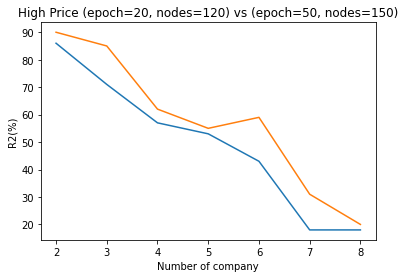

In [ ]:
# 集計データ {time_step=60days, number_of_epoch=20time, number_of_neuron=120, normalised}
# R2_High_20_120={"2":0.86,"3":0.71,"4":0.57,"5":0.53,"6":0.43,"7":0.18,"8":0.18}
# R2_High_50_150={"2":0.90,"3":0.85,"4":0.62,"5":0.55,"6":0.59,"7":0.31,"8":0.20}
# R2_Score_Volume={"2":0.01,"3":0.009,"4":-0.13} # no meanigful result

R2_High_20_120_2016={"2":0.90,"3":0.85,"4":0.57,"5":0.55,"6":0.59,"7":0.31,"8":0.20}
R2_High_20_120_2016_window={"2":0.90,"3":0.85,"4":0.67,"5":0.47,"6":0.43,"7":0.34,"8":0.39}

# Note: Tesco's stock price movement can be tricy, this influence the overall R2. 

import matplotlib.pyplot as plt
x = [i for i in range(2, 9)]
v=100
y1 = [0.86*v, 0.71*v, 0.57*v, 0.53*v, 0.43*v, 0.18*v, 0.18*v]
y2 = [0.90*v, 0.85*v, 0.62*v, 0.55*v, 0.59*v, 0.31*v, 0.20*v]
y3 = []
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.title('High Price (epoch=20, nodes=120) vs (epoch=50, nodes=150)')
plt.xlabel('Number of company')
plt.ylabel('R2(%)')


# N=4

In [8]:
data=[df1, df2, df3, df4] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)']
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

outputs_company=4
cross_validation=False # or False

In [9]:
# default: make_models(c, nl, v, V=False, output_c=['High'], output_i=[2], outputs_company=1, cross_validation=True, train_size=754, time_step=60, epochs=30, units=50): 
o3, o4 = make_models(data, company_list, input, V, output_c, output_i, outputs_company, cross_validation, train_size, time_step, epochs, units)

train_data=(4, 754, 1), test_data=(4, 252, 1)
volule以外かつinputとoutputは1つ
num_of_companies=4, ind=[0, 1, 2, 3]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
Check
1/4
Epoch 1/20
22/22 [==============================] - 29s 255ms/step - loss: 0.6316
Epoch 2/20
22/22 [==============================] - 6s 251ms/step - loss: 0.3417
Epoch 3/20
22/22 [==============================] - 6s 252ms/step - loss: 0.2899
Epoch 4/20
22/22 [==============================] - 6s 254ms/step - loss: 0.2638
Epoch 5/20
22/22 [==============================] - 6s 253ms/step - loss: 0.2702
Epoch 6/20
22/22 [==============================] - 6s 252ms/step - loss: 0.2365
Epoch 7/20
22/22 [==============================] - 6s 253ms/step - loss: 0.2090
Epoch 8/20
22/22 [==============================] - 6s 255ms/step - loss: 0.2043
Epoch 9/20
22/22 [==============================] - 6s 255ms/step - loss: 0.2014
Epoch 10/20
22/22 [==============================] - 5s 249ms/step - loss: 0.2047
Epoch 11/20

train_data=(4, 754, 1), test_data=(4, 252, 1)
inputs = (4, 312, 1)
inputs2=(312, 4)
X_test=(252, 60, 4)
finish making predictions
actual lists=(4, 252), preds_list=(4, 252, 1)
[3]
R2Seven & I Holdings (Japan)=0.5829851876809597


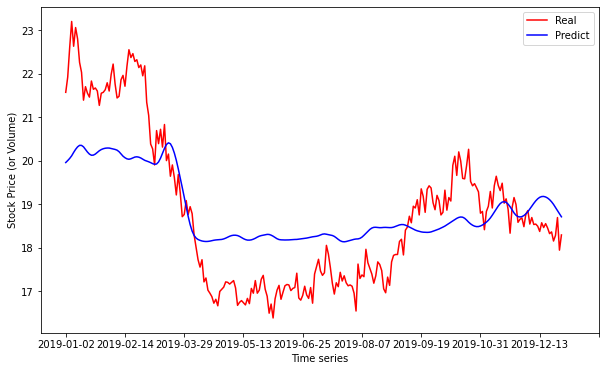

R2Walgreens Boots Alliance (USA)=0.5217573838060864


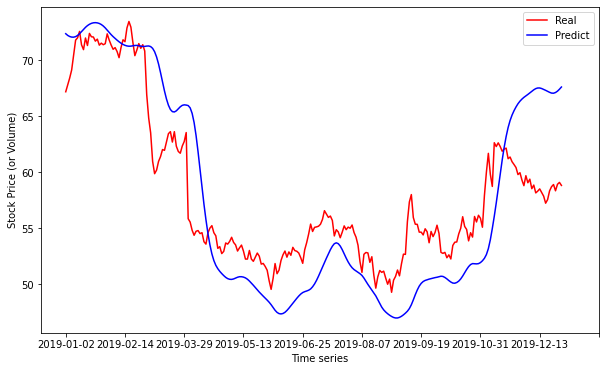

R2Metro (Canada)=0.7118920549324322


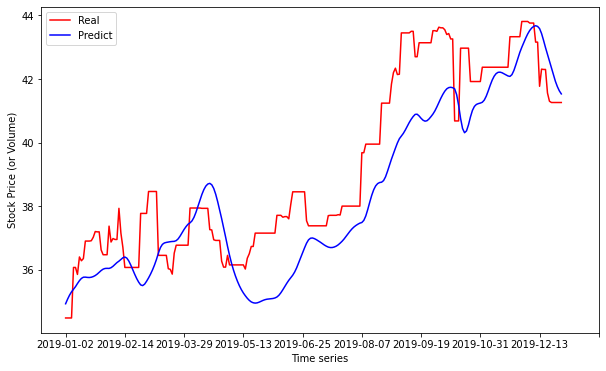

R2Coop Group (Switzerland)=0.44352978979275626


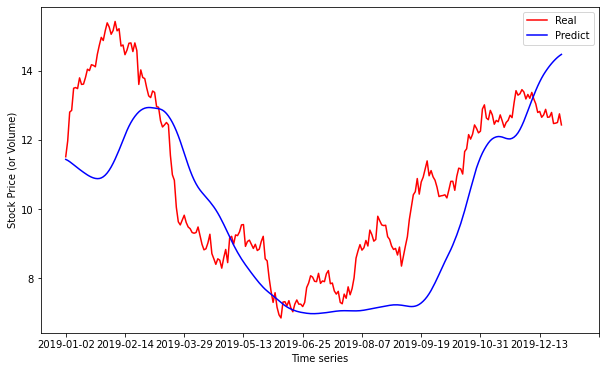

R2-4companies_average=0.5650411040530586

Preds_Heatmap=High correlation


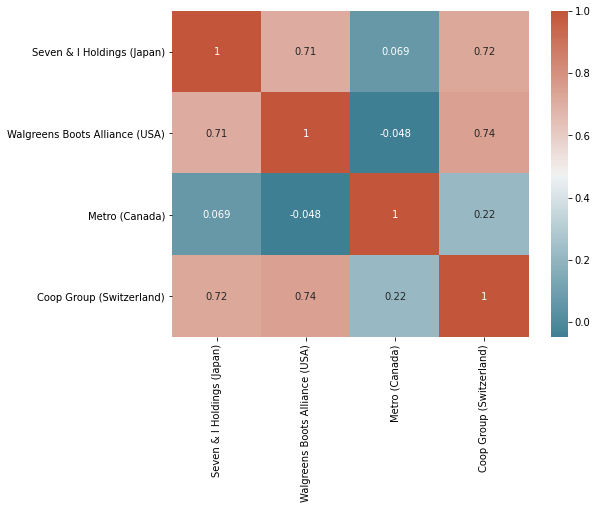

In [10]:
# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

In [20]:
data=[df1, df2, df3, df4] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)']
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input: V=False
else: V=True


outputs_company=5
cross_validation=False # or False

# train 
o3, o4 = make_models(data, company_list, input, V, output_c, output_i, 
                     outputs_company, cross_validation, train_size, time_step, epochs, units)

# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

train_data=(4, 754, 1), test_data=(4, 252, 1)
volule以外かつinputとoutputは1つ
num_of_companies=4, ind=[0, 1, 2, 3]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
Check
1/5
Epoch 1/20
22/22 [==============================] - 17s 261ms/step - loss: 0.6682
Epoch 2/20
22/22 [==============================] - 6s 260ms/step - loss: 0.3850
Epoch 3/20
22/22 [==============================] - 6s 262ms/step - loss: 0.2764
Epoch 4/20
22/22 [==============================] - 6s 261ms/step - loss: 0.2381
Epoch 5/20
22/22 [==============================] - 6s 259ms/step - loss: 0.2266
Epoch 6/20
22/22 [==============================] - 6s 259ms/step - loss: 0.2557
Epoch 7/20
22/22 [==============================] - 6s 262ms/step - loss: 0.2252
Epoch 8/20
22/22 [==============================] - 6s 259ms/step - loss: 0.1991
Epoch 9/20
22/22 [==============================] - 6s 257ms/step - loss: 0.2267
Epoch 10/20
22/22 [==============================] - 6s 262ms/step - loss: 0.1786
Epoch 11/20

IndexError: ignored

In [ ]:
data=[df1, df2, df3, df4, df5, df6] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)',  'J.Sainsbury(Britain)',
    "Royal Ahold Delhaize(Netherlands)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754+126
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input: V=False
else: V=True


outputs_company=6
cross_validation=False # or False

# train 
o3, o4 = make_models(data, company_list, input, V, output_c, output_i, 
                     outputs_company, cross_validation, train_size, time_step, epochs, units)

# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

In [ ]:
data=[df1, df2, df3, df4, df5 ,df6, df7] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)',
    "Royal Ahold Delhaize(Netherlands)", "Tesco(Britain)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754+126
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input: V=False
else: V=True


outputs_company=4
cross_validation=False # or False

# train 
o3, o4 = make_models(data, company_list, input, V, output_c, output_i, 
                     outputs_company, cross_validation, train_size, time_step, epochs, units)

# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

In [ ]:
data=[df1, df2, df3, df4, df5, df6, df7, df8] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)',
    "Royal Ahold Delhaize(Netherlands)", "Tesco(Britain)", "Kroger(USA)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754+126
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input: V=False
else: V=True


outputs_company=4
cross_validation=False # or False

# train 
o3, o4 = make_models(data, company_list, input, V, output_c, output_i, 
                     outputs_company, cross_validation, train_size, time_step, epochs, units)

# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

# Change window size (3years : 1year => 3.5years : 0.5years)

train_data=(4, 880, 1), test_data=(4, 126, 1)
volule以外かつinputとoutputは1つ
num_of_companies=4, ind=[0, 1, 2, 3]
X_train=(820, 60, 4), y_trains=(3280,)
y_trains2=(4, 820)
Check
1/4
Epoch 1/20
26/26 [==============================] - 13s 252ms/step - loss: 0.4358
Epoch 2/20
26/26 [==============================] - 6s 249ms/step - loss: 0.1989
Epoch 3/20
26/26 [==============================] - 6s 248ms/step - loss: 0.1717
Epoch 4/20
26/26 [==============================] - 6s 248ms/step - loss: 0.1587
Epoch 5/20
26/26 [==============================] - 6s 249ms/step - loss: 0.1311
Epoch 6/20
26/26 [==============================] - 7s 250ms/step - loss: 0.1366
Epoch 7/20
26/26 [==============================] - 7s 253ms/step - loss: 0.1132
Epoch 8/20
26/26 [==============================] - 7s 258ms/step - loss: 0.1071
Epoch 9/20
26/26 [==============================] - 7s 255ms/step - loss: 0.1039
Epoch 10/20
26/26 [==============================] - 7s 251ms/step - loss: 0.1036
Epoch 11/20

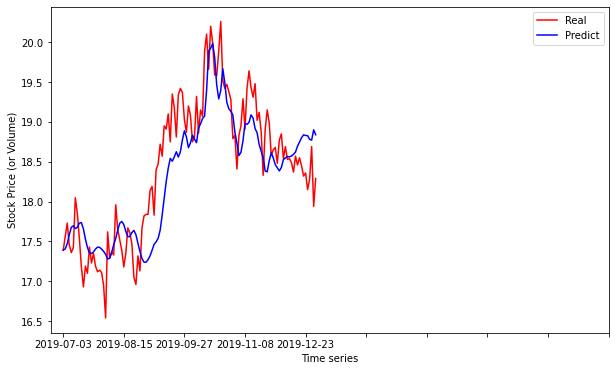

R2Walgreens Boots Alliance (USA)=0.6662008753279177


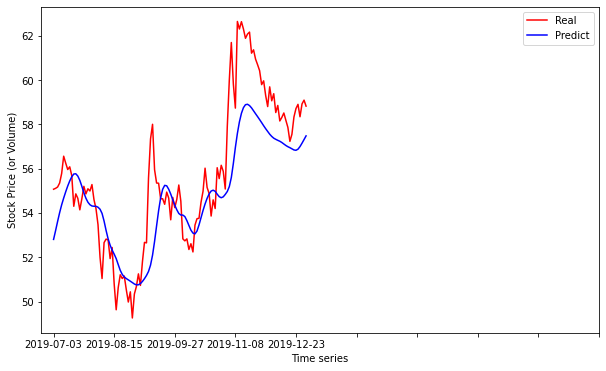

R2Metro (Canada)=0.6933469108139192


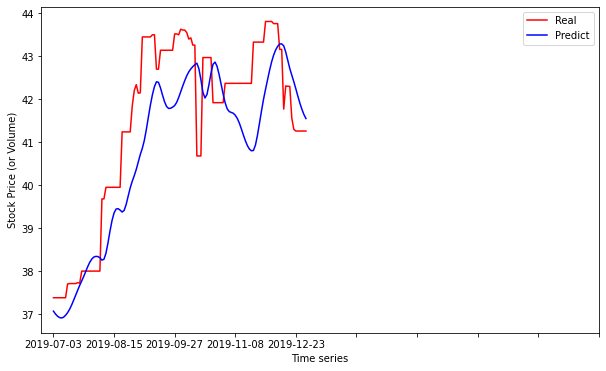

R2Coop Group (Switzerland)=0.597719877330849


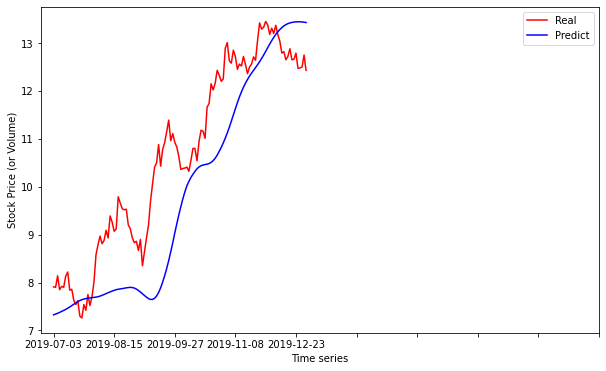

R2-4companies_average=0.6746641962231207

Preds_Heatmap=High correlation


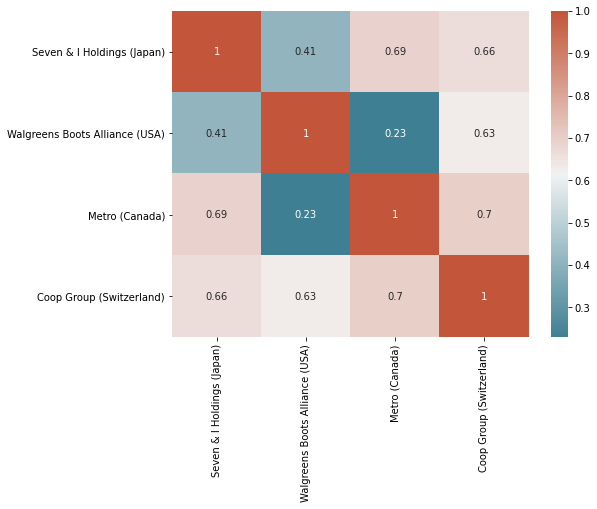

In [12]:
data=[df1, df2, df3, df4] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)']
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754+126
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input: V=False
else: V=True


outputs_company=4
cross_validation=False # or False

# train 
o3, o4 = make_models(data, company_list, input, V, output_c, output_i, 
                     outputs_company, cross_validation, train_size, time_step, epochs, units)

# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

train_data=(5, 880, 1), test_data=(5, 126, 1)
volule以外かつinputとoutputは1つ
num_of_companies=5, ind=[0, 1, 2, 3, 4]
X_train=(820, 60, 5), y_trains=(4100,)
y_trains2=(5, 820)
Check
1/5
Epoch 1/20
26/26 [==============================] - 14s 258ms/step - loss: 0.6183
Epoch 2/20
26/26 [==============================] - 7s 258ms/step - loss: 0.2020
Epoch 3/20
26/26 [==============================] - 7s 259ms/step - loss: 0.1637
Epoch 4/20
26/26 [==============================] - 7s 256ms/step - loss: 0.1482
Epoch 5/20
26/26 [==============================] - 7s 252ms/step - loss: 0.1374
Epoch 6/20
26/26 [==============================] - 7s 254ms/step - loss: 0.1209
Epoch 7/20
26/26 [==============================] - 7s 258ms/step - loss: 0.1193
Epoch 8/20
26/26 [==============================] - 7s 255ms/step - loss: 0.1155
Epoch 9/20
26/26 [==============================] - 7s 255ms/step - loss: 0.1066
Epoch 10/20
26/26 [==============================] - 7s 253ms/step - loss: 0.1081
Epoch 11

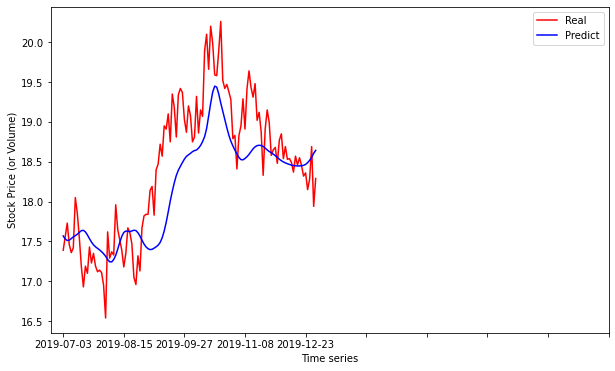

R2Walgreens Boots Alliance (USA)=0.3579757090713853


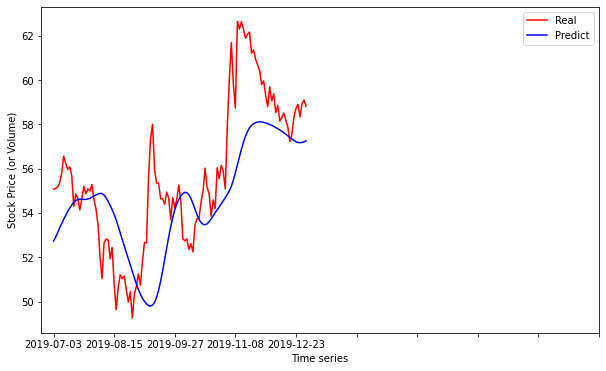

R2Metro (Canada)=0.8007579405485635


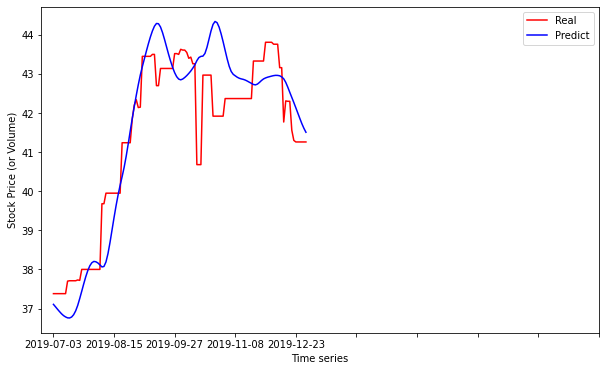

R2Coop Group (Switzerland)=0.32498418953615793


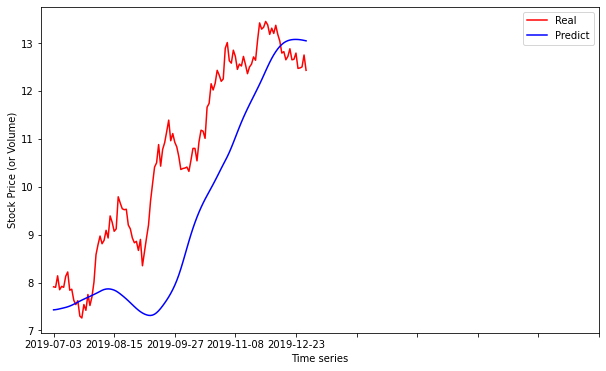

R2J.Sainsbury(Britain)=0.2743213074359143


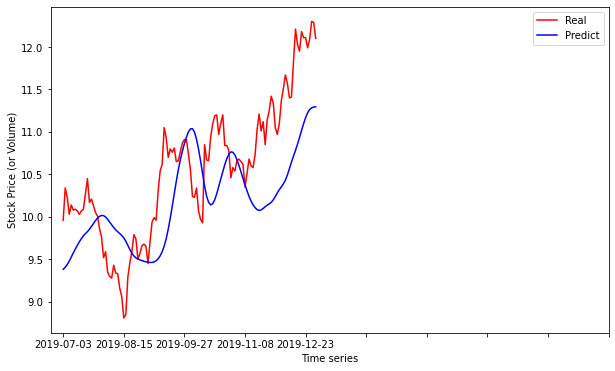

R2-5companies_average=0.47481972289885166

Preds_Heatmap=High correlation


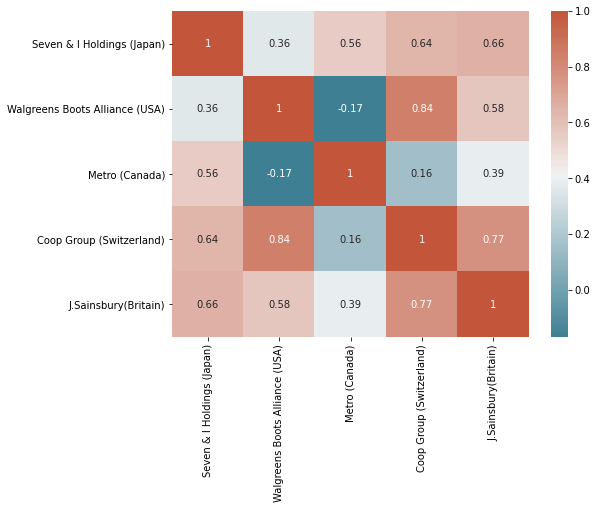

In [14]:
data=[df1, df2, df3, df4, df5] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)']
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754+126
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input: V=False
else: V=True


outputs_company=5
cross_validation=False # or False

# train 
o3, o4 = make_models(data, company_list, input, V, output_c, output_i, 
                     outputs_company, cross_validation, train_size, time_step, epochs, units)

# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

train_data=(6, 880, 1), test_data=(6, 126, 1)
volule以外かつinputとoutputは1つ
num_of_companies=6, ind=[0, 1, 2, 3, 4, 5]
X_train=(820, 60, 6), y_trains=(4920,)
y_trains2=(6, 820)
Check
1/6
Epoch 1/20
26/26 [==============================] - 14s 259ms/step - loss: 0.4774
Epoch 2/20
26/26 [==============================] - 7s 265ms/step - loss: 0.1625
Epoch 3/20
26/26 [==============================] - 7s 259ms/step - loss: 0.1782
Epoch 4/20
26/26 [==============================] - 7s 258ms/step - loss: 0.1367
Epoch 5/20
26/26 [==============================] - 7s 261ms/step - loss: 0.1355
Epoch 6/20
26/26 [==============================] - 7s 263ms/step - loss: 0.1205
Epoch 7/20
26/26 [==============================] - 7s 257ms/step - loss: 0.1064
Epoch 8/20
26/26 [==============================] - 7s 260ms/step - loss: 0.1078
Epoch 9/20
26/26 [==============================] - 7s 256ms/step - loss: 0.0990
Epoch 10/20
26/26 [==============================] - 7s 259ms/step - loss: 0.0920
Epoch

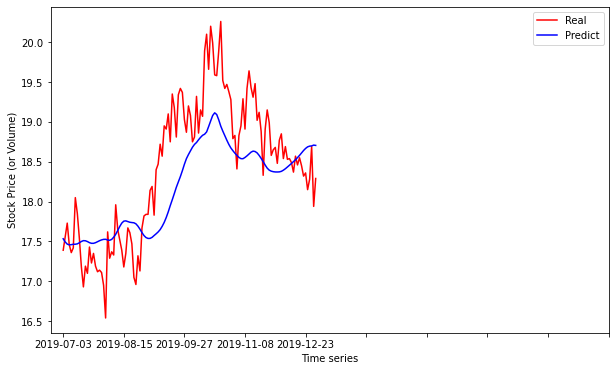

R2Walgreens Boots Alliance (USA)=0.32837375729131857


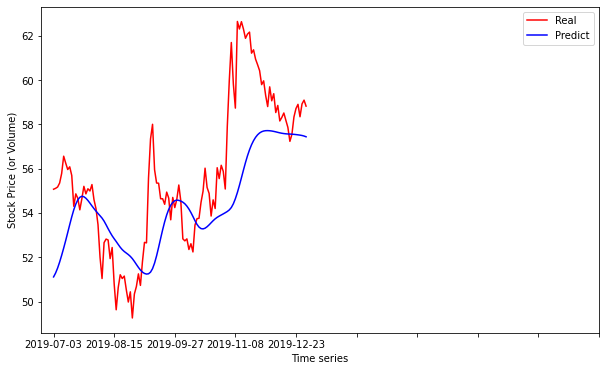

R2Metro (Canada)=0.6016229311149184


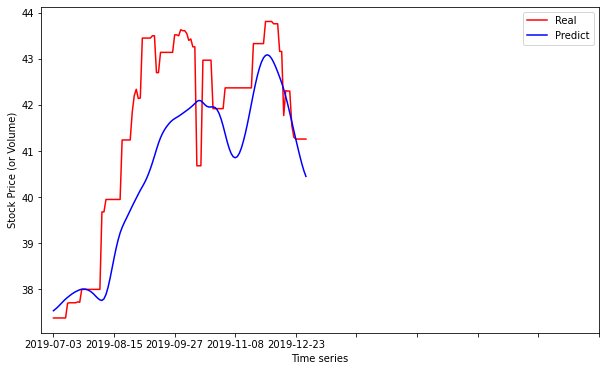

R2Coop Group (Switzerland)=0.5348710069629301


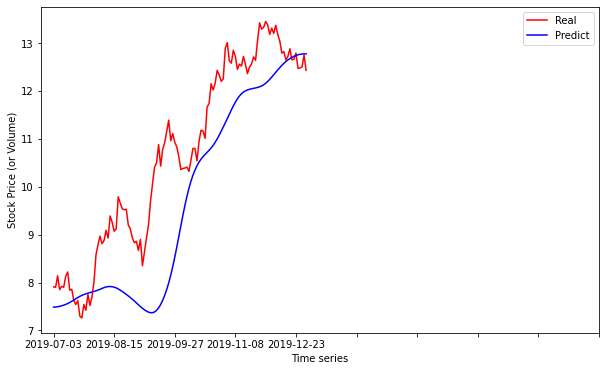

R2J.Sainsbury(Britain)=-0.1035309649441929


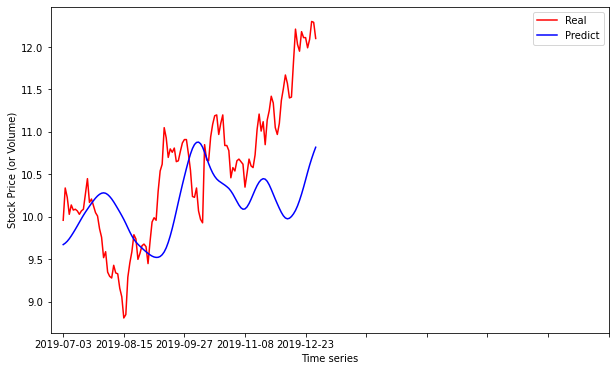

R2Royal Ahold Delhaize(Netherlands)=0.6358286933495725


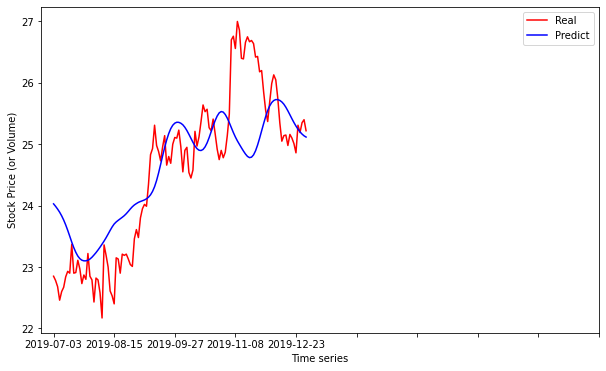

R2-6companies_average=0.42592341327159405

Preds_Heatmap=High correlation


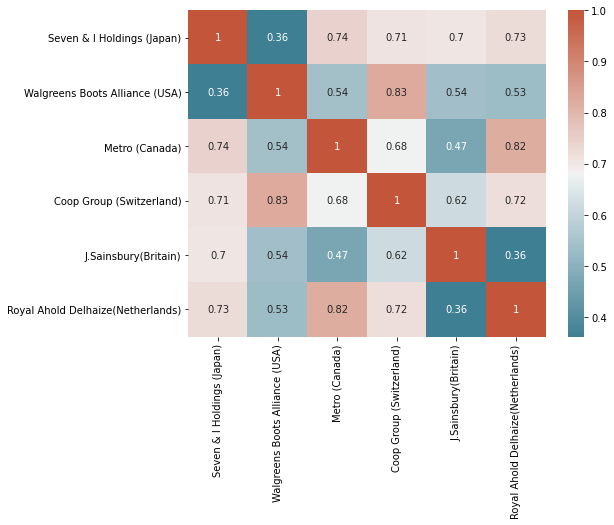

In [16]:
data=[df1, df2, df3, df4, df5, df6] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)',
              "Royal Ahold Delhaize(Netherlands)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754+126
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input: V=False
else: V=True


outputs_company=6
cross_validation=False # or False

# train 
o3, o4 = make_models(data, company_list, input, V, output_c, output_i, 
                     outputs_company, cross_validation, train_size, time_step, epochs, units)

# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

train_data=(7, 880, 1), test_data=(7, 126, 1)
volule以外かつinputとoutputは1つ
num_of_companies=7, ind=[0, 1, 2, 3, 4, 5, 6]
X_train=(820, 60, 7), y_trains=(5740,)
y_trains2=(7, 820)
Check
1/7
Epoch 1/20
26/26 [==============================] - 15s 264ms/step - loss: 0.6226
Epoch 2/20
26/26 [==============================] - 7s 264ms/step - loss: 0.1902
Epoch 3/20
26/26 [==============================] - 7s 259ms/step - loss: 0.1548
Epoch 4/20
26/26 [==============================] - 7s 261ms/step - loss: 0.1444
Epoch 5/20
26/26 [==============================] - 7s 262ms/step - loss: 0.1449
Epoch 6/20
26/26 [==============================] - 7s 264ms/step - loss: 0.1234
Epoch 7/20
26/26 [==============================] - 7s 261ms/step - loss: 0.1217
Epoch 8/20
26/26 [==============================] - 7s 260ms/step - loss: 0.1177
Epoch 9/20
26/26 [==============================] - 7s 261ms/step - loss: 0.1030
Epoch 10/20
26/26 [==============================] - 7s 257ms/step - loss: 0.1036
Ep

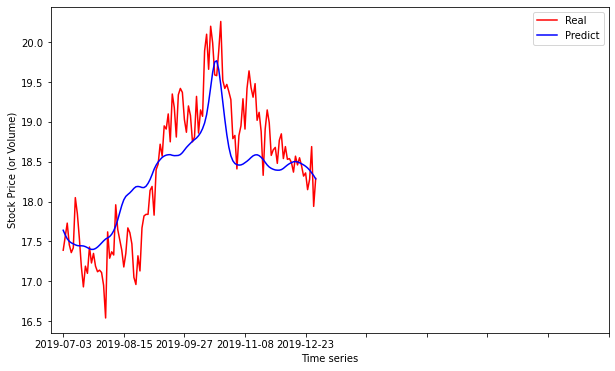

R2Walgreens Boots Alliance (USA)=0.016284612927167652


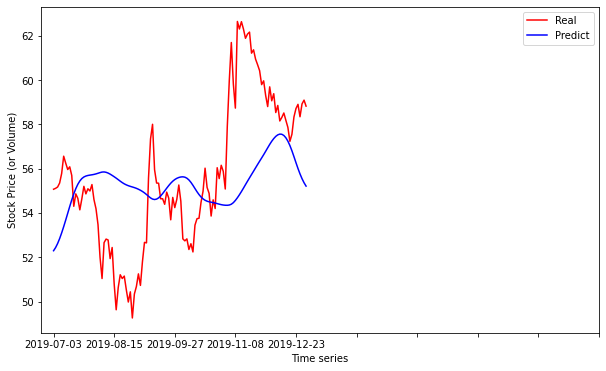

R2Metro (Canada)=0.4613371441240868


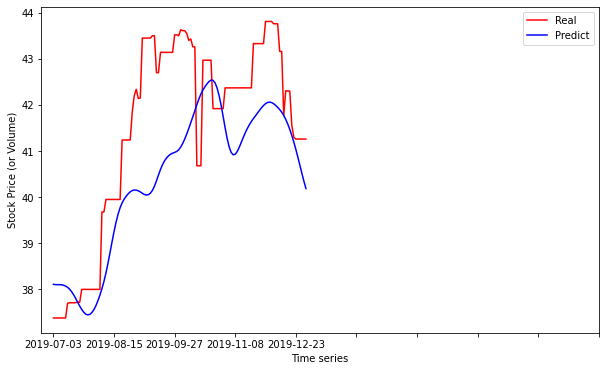

R2Coop Group (Switzerland)=0.5253968234080685


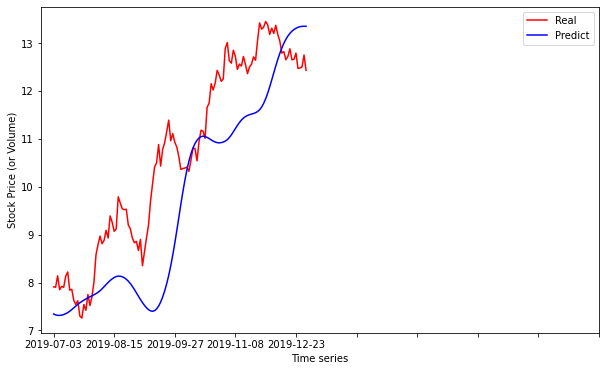

R2J.Sainsbury(Britain)=-0.23426435483711172


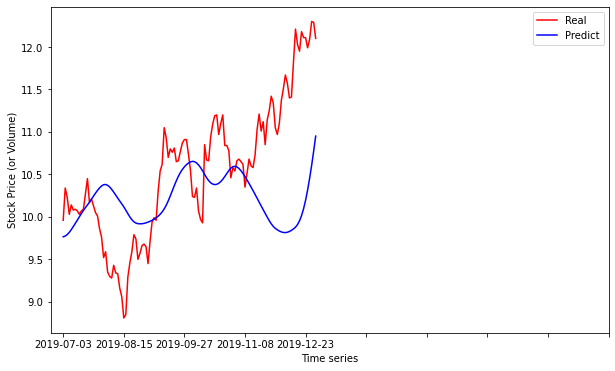

R2Royal Ahold Delhaize(Netherlands)=0.7087971415680774


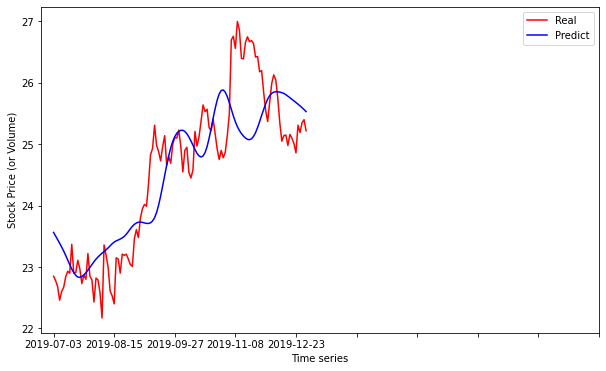

R2Tesco(Britain)=0.2063899368970732


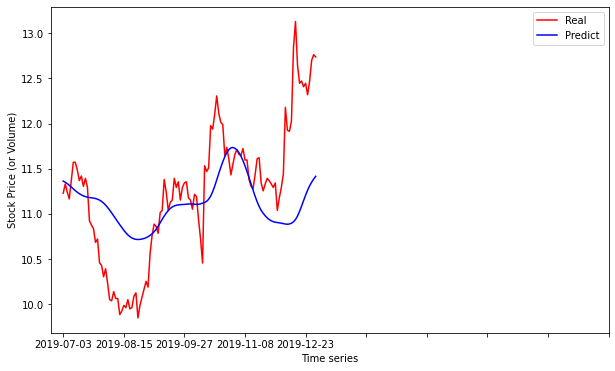

R2-7companies_average=0.33994726494602656

Preds_Heatmap=High correlation


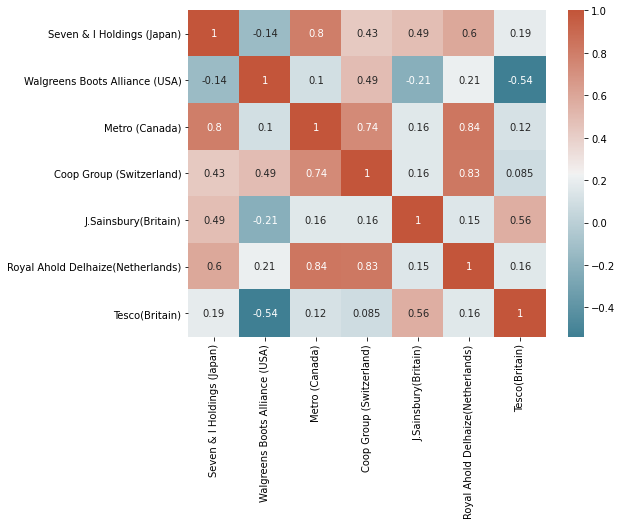

In [18]:
data=[df1, df2, df3, df4, df5, df6, df7] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)',
              "Royal Ahold Delhaize(Netherlands)","Tesco(Britain)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754+126
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input: V=False
else: V=True


outputs_company=7
cross_validation=False # or False

# train 
o3, o4 = make_models(data, company_list, input, V, output_c, output_i, 
                     outputs_company, cross_validation, train_size, time_step, epochs, units)

# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

train_data=(8, 880, 1), test_data=(8, 126, 1)
volule以外かつinputとoutputは1つ
num_of_companies=8, ind=[0, 1, 2, 3, 4, 5, 6, 7]
X_train=(820, 60, 8), y_trains=(6560,)
y_trains2=(8, 820)
Check
1/8
Epoch 1/20
26/26 [==============================] - 17s 262ms/step - loss: 0.4368
Epoch 2/20
26/26 [==============================] - 7s 257ms/step - loss: 0.1625
Epoch 3/20
26/26 [==============================] - 7s 260ms/step - loss: 0.1456
Epoch 4/20
26/26 [==============================] - 7s 257ms/step - loss: 0.1511
Epoch 5/20
26/26 [==============================] - 7s 261ms/step - loss: 0.1255
Epoch 6/20
26/26 [==============================] - 7s 256ms/step - loss: 0.1078
Epoch 7/20
26/26 [==============================] - 7s 255ms/step - loss: 0.1182
Epoch 8/20
26/26 [==============================] - 7s 257ms/step - loss: 0.1124
Epoch 9/20
26/26 [==============================] - 7s 255ms/step - loss: 0.1046
Epoch 10/20
26/26 [==============================] - 7s 258ms/step - loss: 0.0792

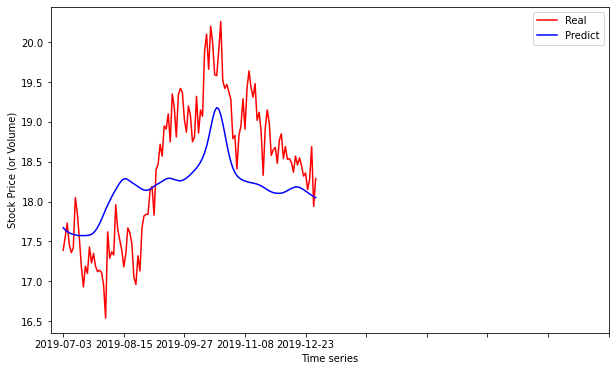

R2Walgreens Boots Alliance (USA)=-0.05443615729754647


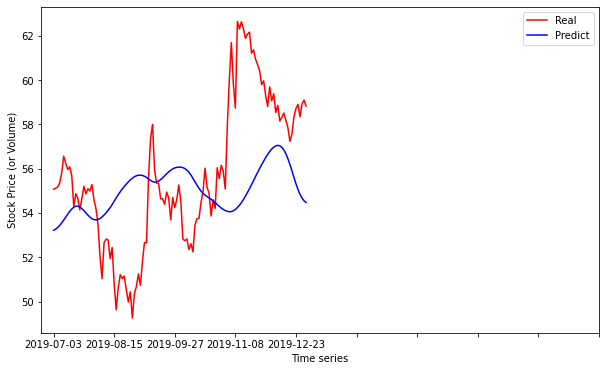

R2Metro (Canada)=0.4878714619264949


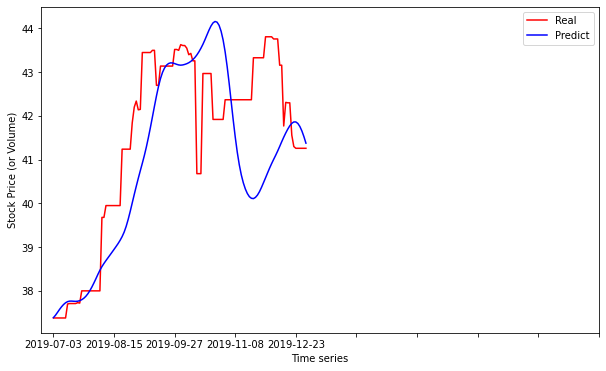

R2Coop Group (Switzerland)=0.6504275481236721


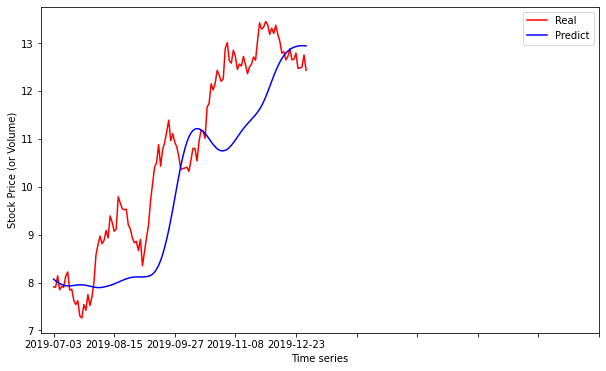

R2J.Sainsbury(Britain)=0.1690159468745508


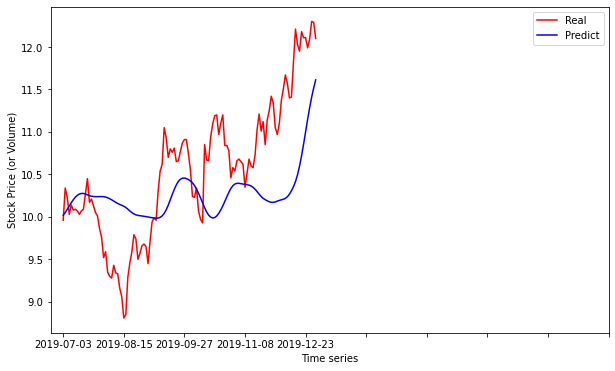

R2Royal Ahold Delhaize(Netherlands)=0.7692133033638912


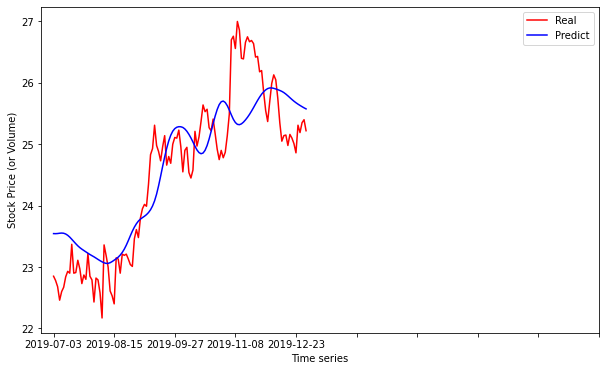

R2Tesco(Britain)=0.034903635854981574


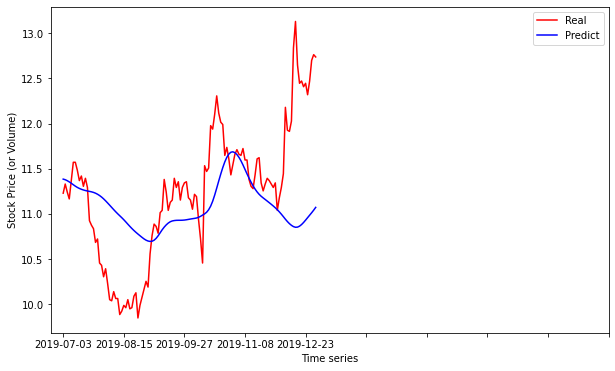

R2Kroger(USA)=0.7319881048090044


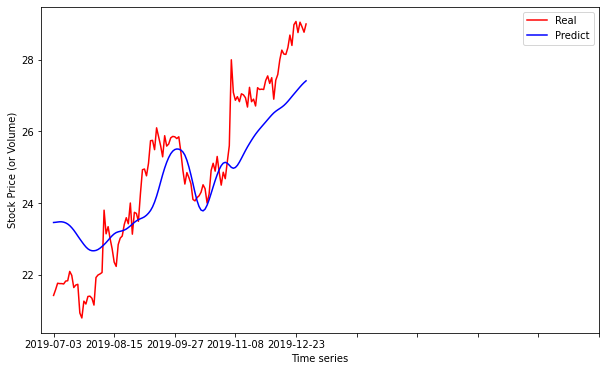

R2-8companies_average=0.39498566823499237

Preds_Heatmap=High correlation


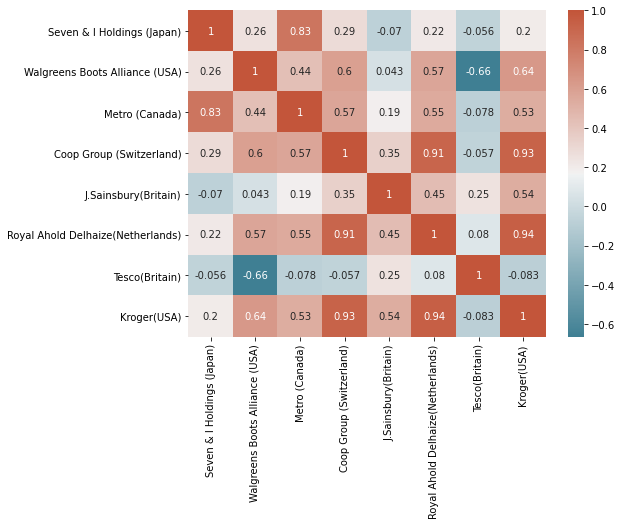

In [19]:
data=[df1, df2, df3, df4, df5, df6, df7, df8] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)',
              "Royal Ahold Delhaize(Netherlands)","Tesco(Britain)", "Kroger(USA)",]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754+126
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input: V=False
else: V=True


outputs_company=8
cross_validation=False # or False

# train 
o3, o4 = make_models(data, company_list, input, V, output_c, output_i, 
                     outputs_company, cross_validation, train_size, time_step, epochs, units)

# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)